In [1]:
import librosa
import os
import random
import numpy as np
import csv
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable
from sklearn import metrics
from google.colab import drive

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!ls /content/gdrive/My\ Drive/End-to-end_accented4
os.chdir('/content/gdrive/My Drive/End-to-end_accented4')

GRU_model4  X_train.npy  Y_test.npy   Y_val.npy
X_test.npy  X_val.npy	 Y_train.npy


In [4]:
X_train = np.load("X_train.npy")
X_val = np.load("X_val.npy")
X_test = np.load("X_test.npy")

Y_train = np.load("Y_train.npy")
Y_val = np.load("Y_val.npy")
Y_test = np.load("Y_test.npy")

In [5]:
class Accent_dataset(Dataset): 
  def __init__(self,x_data,y_data):
    
    self.x_data=x_data[:,:]
    self.y_data=y_data[:]

    self.x_data = self.x_data.reshape(-1,237, 13)
    self.y_data = self.y_data.reshape(-1)

    self.x_data = torch.cuda.FloatTensor(self.x_data)
    self.y_data = torch.cuda.LongTensor(self.y_data)

    print("=== Dataset Download Complete !!")
    print("X shape:",self.x_data.shape)
    print("Y shape:",self.y_data.shape)

    self.len = len(self.x_data)

  def __getitem__(self, index): 
    return self.x_data[index], self.y_data[index] 

  def __len__(self): 
    return self.len

In [6]:
#parameters

num_epochs=200
learning_rate=0.0001
batch_size=512

In [7]:
train_dataset = Accent_dataset(X_train,Y_train)
val_dataset = Accent_dataset(X_val,Y_val)  
test_dataset = Accent_dataset(X_test,Y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


=== Dataset Download Complete !!
X shape: torch.Size([18000, 237, 13])
Y shape: torch.Size([18000])
=== Dataset Download Complete !!
X shape: torch.Size([6000, 237, 13])
Y shape: torch.Size([6000])
=== Dataset Download Complete !!
X shape: torch.Size([6000, 237, 13])
Y shape: torch.Size([6000])


In [8]:
#device setting

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print(device)

cuda


In [9]:
#gru model

class GRU_model(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers,batch_first=True):
        super(GRU_model,self).__init__()

        self.input_size=input_size
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.num_layers=num_layers

        self.gru=nn.GRU(input_size=self.input_size,hidden_size=self.hidden_size,num_layers=self.num_layers,batch_first=True) #batch, seq_len, feature

        # Readout layer
        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self,x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        out,hn = self.gru(x, h0.detach())

        # Decode the hidden state of the last time step
        out = self.fc(out[:,-1])

        return out

gru_model=GRU_model(13,100,3,1).to(device)
print(gru_model)

GRU_model(
  (gru): GRU(13, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate)
#, weight_decay=0.001
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

Training start
Epoch:    0/200 | Train loss: 0.010980
Epoch:    0/200 | Validation loss: 1.092728
[Validation set] ERR: 0.634500 | ACC: 0.365500 (2193 / 6000)

Epoch:   10/200 | Train loss: 0.009530
Epoch:   10/200 | Validation loss: 0.932953
[Validation set] ERR: 0.494500 | ACC: 0.505500 (3033 / 6000)

Epoch:   20/200 | Train loss: 0.008125
Epoch:   20/200 | Validation loss: 0.811697
[Validation set] ERR: 0.420333 | ACC: 0.579667 (3478 / 6000)

Epoch:   30/200 | Train loss: 0.006319
Epoch:   30/200 | Validation loss: 0.754150
[Validation set] ERR: 0.391167 | ACC: 0.608833 (3653 / 6000)

Epoch:   40/200 | Train loss: 0.005423
Epoch:   40/200 | Validation loss: 0.523574
[Validation set] ERR: 0.206500 | ACC: 0.793500 (4761 / 6000)

Epoch:   50/200 | Train loss: 0.002897
Epoch:   50/200 | Validation loss: 0.417015
[Validation set] ERR: 0.162167 | ACC: 0.837833 (5027 / 6000)

Epoch:   60/200 | Train loss: 0.001944
Epoch:   60/200 | Validation loss: 0.359827
[Validation set] ERR: 0.137167 |

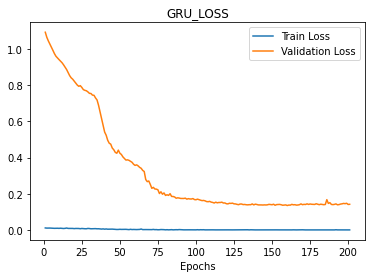

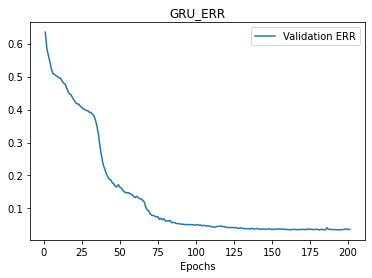

<Figure size 432x288 with 0 Axes>

In [11]:
print("Training start")

train_loss_list=[]
val_loss_list=[]

x_step=[]
y_err=[]

val_predicted_class = []
val_actual_class = []

for epoch in range(num_epochs+1):
  for i, train_data in enumerate(train_loader):
    
    tain_loss = 0.0

    train_accent, train_label = train_data
  
    train_accent=train_accent.to(device)
    train_label=train_label.to(device)
    
    optimizer.zero_grad()

    hypothesis = gru_model(train_accent).to(device)
    trn_loss = criterion(hypothesis, train_label)

    trn_loss.backward()
    optimizer.step()

    tain_loss+=trn_loss

    with torch.no_grad():

      val_loss=0.0
      correct = 0
      total = 0

      for j,val_data in enumerate(val_loader):
        val_accent, val_label = val_data
      
        val_accent=val_accent.to(device)
        val_label=val_label.to(device)

        prediction = gru_model(val_accent)
        vl_loss = criterion(prediction, val_label)
  
        _, predicted = torch.max(prediction.data, 1)

        val_loss+=vl_loss*len(val_label)
        total += val_label.size(0)
        correct += (predicted == val_label).sum()

        val_predicted_class.extend(predicted.tolist())
        val_actual_class.extend(val_label.tolist())
    
    correct = int(correct)
    total = int(total)

  if epoch % 10==0:
    print('Epoch: {:4d}/{} | Train loss: {:.6f}'.format(epoch, num_epochs, tain_loss / 100))
    print("Epoch: {:4d}/{} | Validation loss: {:.6f}".format(epoch, num_epochs, val_loss / total))
    print('[Validation set] ERR: %f | ACC: %f (%d / %d)' % (1 - (correct / total), correct / total, correct, total))
    print()

  #scheduler.step(val_loss)
        
  train_loss_list.append(tain_loss/100)
  val_loss_list.append(val_loss/total)
  train_loss = 0.0

  x_step.append(epoch+1)
  y_err.append(1 - (correct / total))

plt.plot(x_step, train_loss_list, label = "Train Loss")
plt.plot(x_step, val_loss_list, label = "Validation Loss")
plt.xlabel('Epochs')
plt.title('GRU_LOSS')
plt.legend()
plt.savefig('GRU_LOSS.png')
plt.show()
plt.clf()

plt.plot(x_step, y_err, label = "Validation ERR")
plt.xlabel('Epochs')
plt.title('GRU_ERR')
plt.legend()
plt.savefig('GRU_ERR.png')
plt.show()
plt.clf()

[[11489478  1819201  1163321]
 [ 1449795 12244995   777210]
 [  397002   375796 13699202]]
              precision    recall  f1-score   support

           0       0.86      0.79      0.83  14472000
           1       0.85      0.85      0.85  14472000
           2       0.88      0.95      0.91  14472000

    accuracy                           0.86  43416000
   macro avg       0.86      0.86      0.86  43416000
weighted avg       0.86      0.86      0.86  43416000



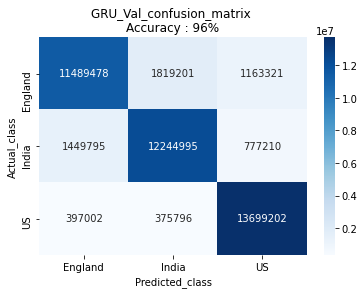

<Figure size 432x288 with 0 Axes>

In [12]:
#Precision (정밀도) : 모델이 Positive라 분류한 것 중 실제값이 Positive인 비율
#Recall (재현도) : 실제값이 Positive인 것 중 모델이 Positive라 분류한 비율
#F1 Score : Precision과 Recall의 조화평균

#0,1,2=England, India, US

print(metrics.confusion_matrix(y_true=val_actual_class, y_pred=val_predicted_class, labels=[0,1,2]))
print(metrics.classification_report(y_true=val_actual_class, y_pred=val_predicted_class, labels=[0,1,2]))

val_confusion = metrics.confusion_matrix(val_actual_class,val_predicted_class)
val_confusion_df=pd.DataFrame(val_confusion,index=['England','India','US'],columns=['England','India','US'])

sns.heatmap(val_confusion_df, annot=True,fmt='d',cmap="Blues")
plt.title('GRU_Val_confusion_matrix \nAccuracy : %d%%' % (100 * correct / total))
plt.xlabel('Predicted_class')
plt.ylabel('Actual_class')
plt.savefig('GRU_Val_confusion_matrix.png')
plt.show()
plt.clf()

In [13]:
print("Test start")

test_correct = 0
test_total = 0

test_actual_class=[]
test_predicted_class=[]

with torch.no_grad():
    for k,test_data in enumerate(test_loader):
        test_accent, test_label = test_data

        test_accent=test_accent.to(device)
        test_label=test_label.to(device)

        test_prediction = gru_model(test_accent)

        _, test_predicted = torch.max(test_prediction.data, 1)

        test_predicted_class.extend(test_predicted.tolist())
        test_actual_class.extend(test_label.tolist())

        test_total += test_label.size(0)
        test_correct += (test_predicted == test_label).sum()

        test_correct = int(test_correct)
        test_total = int(test_total)

print('Accuracy of the model on the testset: %d %%' % (100 * test_correct / test_total))

Test start
Accuracy of the model on the testset: 96 %


[[1902   65   33]
 [  73 1897   30]
 [   9    7 1984]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2000
           1       0.96      0.95      0.96      2000
           2       0.97      0.99      0.98      2000

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000



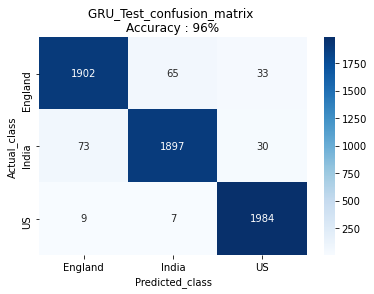

<Figure size 432x288 with 0 Axes>

In [14]:
#Precision (정밀도) : 모델이 Positive라 분류한 것 중 실제값이 Positive인 비율
#Recall (재현도) : 실제값이 Positive인 것 중 모델이 Positive라 분류한 비율
#F1 Score : Precision과 Recall의 조화평균

#0,1,2=England, India, US

print(metrics.confusion_matrix(y_true=test_actual_class, y_pred=test_predicted_class, labels=[0,1,2]))
print(metrics.classification_report(y_true=test_actual_class, y_pred=test_predicted_class, labels=[0,1,2]))

test_confusion = metrics.confusion_matrix(test_actual_class,test_predicted_class)
test_confusion_df=pd.DataFrame(test_confusion,index=['England','India','US'],columns=['England','India','US'])

sns.heatmap(test_confusion_df, annot=True,fmt='d',cmap="Blues")
plt.title('GRU_Test_confusion_matrix \nAccuracy : %d%%' % (100 * test_correct / test_total))
plt.xlabel('Predicted_class')
plt.ylabel('Actual_class')
plt.savefig('GRU_Test_confusion_matrix.png')
plt.show()
plt.clf()